# 任务介绍
---
## 主要目标
现在有美国各个州的COVID相关数据，测试集包含前四天的数据，训练集是第五天的数据，要预测第五天的阳性检出率

---
## 数据集
两个csv文件，文件的结构非常迷，不是正常脑回路想得出来的文件组织结构，所以需要单独介绍

根据数据的内容，我猜测数据的一个id对应某个州下面的一个城市
- covid.train.csv

    训练集。
    - 第一列是数据id，没有用
    - 第二到三十八列是用独热向量表示的美国各州名字，标记为1表示是这个州
    - 接下来的四列表示与COVID相似的症状的数据
    - 紧接着的八列表示可能与COVID相关行为的数据
    - 接着三列是心理因素的数据
    - 然后是最重要的一列，阳性检出率
    
    _*然后，还有四天一样结构的数据*_


- covid.test.csv
    
    和训练集一样的，不过第五天的阳性检出率没有给出
---
## 损失函数
用均方根误差计算


# 第一步：数据读取与预处理

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression

In [2]:
# 用pandas读入csv文件
# header设置为None则文件没有第一行的列名，设置为0则自动读入第一行作为列名
# index_col设置为0或者None，则不重新设置一个以0开始的index了
raw_data = pd.read_csv("./data/covid.train.csv", header=0, index_col=0)

In [3]:
# 注意这里最后一列有.4，pandas自动把重复的名字加以区别了，第一列没有加数字，后面自动加了从1开始的数据
raw_data

,AL,AK,AZ,AR,CA,CO,CT,FL,GA,ID,...,work_outside_home.4,shop.4,restaurant.4,spent_time.4,large_event.4,public_transit.4,anxious.4,depressed.4,worried_finances.4,tested_positive.4
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,1,0,0,...,31.113209,67.394551,36.674291,40.743132,17.842221,4.093712,10.440071,8.627117,37.329512,7.456154
1,0,0,0,0,0,1,0,0,0,0,...,33.920257,64.398380,34.612238,44.035688,17.808103,4.924935,10.172662,9.954333,32.508881,8.010957
2,0,0,0,0,0,0,0,0,0,0,...,31.604604,62.101064,26.521875,36.746453,13.903667,7.313833,10.388712,7.956139,36.745588,2.906977
3,0,0,0,0,0,0,0,0,0,0,...,35.115738,67.935520,38.022492,48.434809,27.134876,3.101904,10.498683,8.231522,38.680162,12.575816
4,0,0,0,0,0,0,0,0,0,1,...,35.129714,69.934592,38.242368,49.095933,22.683709,4.594620,9.878927,9.469290,28.344123,21.428589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695,0,0,0,0,0,0,0,0,0,0,...,39.209278,65.815096,37.046827,46.777637,21.952499,2.724187,14.658436,11.099308,33.154910,13.437482
2696,0,0,0,0,0,0,0,0,0,0,...,28.984491,66.126427,31.299807,40.399527,16.783327,14.058799,13.129031,10.492896,36.670282,5.040143
2697,0,0,0,1,0,0,0,0,0,0,...,34.346100,63.456270,30.829009,41.828908,20.597714,2.391852,16.940896,12.888275,42.452451,13.618256


In [4]:
# 转换为numpy张量
raw_data = np.array(raw_data)

In [5]:
# 转换后的结构是1-37列是州名，之后每16列一组，最后一列是标签，共117列(id不在里面)
raw_data.shape

(2699, 117)

In [6]:
# 封装为读入数据的函数，返回x和y
def read_data(path):
    return np.array(pd.read_csv(path, header=0, index_col=0))

In [7]:
data = read_data("./data/covid.train.csv")
print(data.shape)

(2699, 117)


In [8]:
# 划分数据集
def split_dataset(raw_data):
    # numpy下标从0开始，同时区间划分都是左闭右开的区间，所以是0：-1
    x = raw_data[:, 0:-1] 
    y = raw_data[:, -1]
    train_data_x, val_data_x, train_data_y, val_data_y = train_test_split(x, y, train_size=0.8, shuffle=True, random_state=42)
    return train_data_x, val_data_x, train_data_y, val_data_y

In [9]:
# 特征筛选
# 本来筛选数据集是想通过特征的现实意义分门别类进行筛选的
# 不过可能第n天的某种数据对最后结果的影响更特殊，所以将所有数据视为平等的数据进行筛选
 
def choose_feature(x, y, k=40, select_all=False):
    if select_all:
        return x
    else:
        model = SelectKBest(f_regression, k=k)# 选择k个最佳特征
        x_new = model.fit_transform(x, y)  # 该函数可以选择出k个特征,x_rest_new就是筛选之后的特征 
        scores = model.scores_
        # 按重要性排序，以便选出最重要的 k 个
        indices = np.argsort(scores)[::-1]
        # 找到重要k个的下标
        indices = indices[0:k]
        return x_new, indices

In [10]:
x1, x2, y1, y2 = split_dataset(data)
x1_new, feature1 = choose_feature(x1, y1)

In [11]:
print(x1_new.shape, feature1.shape)

(2159, 40) (40,)


In [12]:
feature1

array([100,  84,  68,  52, 103,  87,  71, 104,  88,  55,  72,  39,  56,
        40, 102, 101,  86,  85,  70,  54,  69,  53,  38,  37, 113,  97,
        81,  65,  49, 107,  91,  75,  59,  43,  66, 114,  82,  98,  50,
       112], dtype=int64)

In [13]:
# 根据筛选的特征取特征列
x2_new = x2[:, feature1]

In [14]:
x2_new.shape

(540, 40)

# 第二步：封装成dataset类

In [15]:
import torch
from torch.utils.data import Dataset

In [16]:
class CovidDataset(Dataset):
    def __init__(self, filepath, mode, feature_dim, feature_index=None):
        '''
        filepath:os_path，csv数据的存储路径
        mode:str，Dataset的模式，可选：'train', 'val', 'test'
        feature_dim:int，选取出来的有用特征
        feature_index:list，存储使用的特征的列表，只有在test模式下才需要输入训练时选取的特征以保持一致，否则都是直接生成
        '''
        self.mode = mode
        
        # 读入数据
        data = self.read_data(filepath).astype(float)
        x = data[:, 0:-1] 
        y = data[:, -1] 
        
        # 确定要使用哪些特征列
        if feature_index is not None:
            # 这种情况一定是test模式，外部才有传入选取特征的索引
            if self.mode == 'test':
                feature_idx = feature_index
                y_new = y.reshape(-1, 1)
                x = np.concatenate((x, y_new), axis= 1) 
            else:
                print("Only the TEST mode can get feature index from outside!")       
        else:
            # 否则就选择特征
            x_new, feature_idx = self.choose_feature(x, y, k=feature_dim)
        # 根据idx选x里的列出来
        x = x[:, feature_idx]
        # 把idx保存成参数方便外部获取并使用
        self.feature_used = feature_idx
        
        #确定self.x和self.y
        if self.mode == 'test':
            # 如果是测试集就全部输入
            self.x = x
            self.y = y  # 统一输出结构用的
        elif self.mode == 'train' or self.mode == 'val':
            train_data_x, val_data_x, train_data_y, val_data_y = self.split_dataset(x, y)
            if self.mode == 'train':
                self.x = train_data_x
                self.y = train_data_y
            else:
                self.x = val_data_x
                self.y = val_data_y
        else:
            print("Dataset got an error mode!")
        
        # 把self.x归一化
        # self.x = (self.x - np.mean(self.x, axis=0)) / np.std(self.x, axis=0)
    
    def __getitem__(self, index):
        
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.x.shape[0]
        
    def read_data(self, path):
        return np.array(pd.read_csv(path, header=0, index_col=0))
    
    # 为了减少运算次数，这里把x与y分别，原因的话看init方法的结构就明白咯
    def split_dataset(self, x, y):
        train_data_x, val_data_x, train_data_y, val_data_y = train_test_split(x, y, train_size=0.8, shuffle=True, random_state=42)
        return train_data_x, val_data_x, train_data_y, val_data_y
    
    def choose_feature(self, x, y, k=40, select_all=False):
        if select_all:
            return x
        else:
            model = SelectKBest(f_regression, k=k)# 选择k个最佳特征
            x_new = model.fit_transform(x, y)  # 该函数可以选择出k个特征,x_rest_new就是筛选之后的特征 
            scores = model.scores_
            # 按重要性排序，以便选出最重要的 k 个
            indices = np.argsort(scores)[::-1]
            # 找到重要k个的下标
            indices = indices[0:k]
            return x_new, indices

# 第三步：模型设计

In [17]:
class CovidPredictor(torch.nn.Module):
    def __init__(self, feature_dim):
        super().__init__()
        self.relu = torch.nn.ReLU()
        self.linear1 = torch.nn.Linear(feature_dim, 64)
        self.linear2 = torch.nn.Linear(64, 16)
        self.linear3 = torch.nn.Linear(16, 4)
        self.linear4 = torch.nn.Linear(4, 1)
    
    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        x = self.relu(self.linear4(x))
        x = x.squeeze(1) 
        return x

# 第四步：训练、验证、预测

In [18]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import csv

In [19]:
# 训练函数并在验证集上验证，最后输出训练参数
def train_val_model(train_loader, val_loader, model, loss_function, optimizer, save_path, device):
    '''
    train_loader:训练集dataloader
    val_loader:验证集dataloader
    model:模型
    loss_function:未进行正则化的损失函数
    optimizer:优化器
    save_path:保存模型的路径
    device:CPU/GPU
    '''
    model = model.to(device)
    
    # 定义L2正则化的损失函数
    def get_loss(pred, target, model, loss_function):
        regularization_loss = 0
        for param in model.parameters():
            regularization_loss += torch.sum(param ** 2)
        return loss_function(pred, target) + 0.00075 * regularization_loss

    
    # 初始化
    epoch = 1
    train_loss = 0.0
    val_loss = 0.0
    iter_list = []
    loss_list = []
    val_loss_list = []

    while True:
        # tqdm 是一个库，用于在命令行界面中显示进度条。它可以用于迭代过程
        # train_loader 是你的数据加载器，可能是一个 DataLoader 对象。
        # position=0 表示进度条在命令行界面中的位置，通常是第一行。
        # leave=True 表示在进度条完成后保留它，不清除掉。如果设置为 False，则进度条完成后会被清除。
        for i , data in enumerate(train_loader, 0):
            # 1 准备数据
            inputs, labels = data
            inputs, labels = inputs.to(torch.float32).to(device), labels.reshape(-1, 1).to(torch.float32).to(device)
            # 2 前馈
            y_pred = model(inputs).reshape(-1, 1)
            batch_loss = get_loss(y_pred, labels, model, loss_function)
            # 3 反向传播
            optimizer.zero_grad()
            batch_loss.backward()
            train_loss += batch_loss.detach().cpu().item()  # 记录loss值 注意要从gpu上取下来再从张量里取出来
            # 4 更新
            # 更新操作名叫step是因为相当于沿着梯度下降了一步
            optimizer.step()
        y_val = model(inputs).reshape(-1, 1)
        batch_loss_test = get_loss(y_val, labels, model, loss_function)
        if epoch == 1 or epoch % 10 == 0:
            print(epoch, batch_loss_test.data.item())
        iter_list.append(epoch)
        loss_list.append(batch_loss_test.data.item())
        epoch += 1

        if len(loss_list) > 1:
            if abs(loss_list[-2] - loss_list[-1]) < 0.005:
                print(loss_list[-2], loss_list[-1])
                break

        
    # 在验证集上进行验证
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            val_x, val_y = data
            val_x, val_y = val_x.to(torch.float32).to(device), val_y.reshape(-1, 1).to(torch.float32).to(device)
            val_pred = model(val_x).reshape(-1, 1)
            val_loss = get_loss(val_pred, val_y, model, loss_function)
            val_loss_list.append(val_loss.data.item())
    val_loss_sum = 0
    for i in val_loss_list:
        val_loss_sum += i
    val_loss_avg = val_loss_sum / len(val_loss_list)
    print("Loss in the validation set is:", val_loss_avg)

    # 存储模型
    torch.save(model, save_path)

    return iter_list, loss_list

In [20]:
# 绘制训练过程
def plot_train_process(iter_list, loss_list):
    plt.plot(iter_list, loss_list)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title("The Training Process")
    plt.show()

In [21]:
# 测试
def predict(save_path, test_loader, device):
    model = torch.load(save_path).to(device)
    pred_list = []
    
    model.eval()
    with torch.no_grad():
        for data in tqdm(test_loader):
            x = data[0].to(torch.float32).to(device)
            pred = model(x)
            for i in pred.data:
                pred_list.append(i.item()) 
    
    return pred_list

In [22]:
# 将预测结果写进csv文件
# The predictions of model on testing set will be stored at pred.csv.
def complete_csv(file_path, pred_list):
    with open(file_path, 'w') as f:
        csv_writer = csv.writer(f)
        csv_writer.writerow(['id','tested_positive'])
        for i in range(len(pred_list)):
            csv_writer.writerow([str(i),str(pred_list[i])])

# 第五步：运行

In [23]:
from torch.utils.data import DataLoader
# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter

1 156.794677734375
10 4.597249507904053
20 2.0302343368530273
30 2.0383832454681396
40 1.9283781051635742
50 1.7924261093139648
60 1.5893933773040771
70 1.6103124618530273
80 1.4563148021697998
90 1.3339709043502808
100 1.7340869903564453
110 1.7118300199508667
120 1.8883169889450073
130 1.7409170866012573
1.6038601398468018 1.5999963283538818
Loss in the validation set is: 1.684316635131836


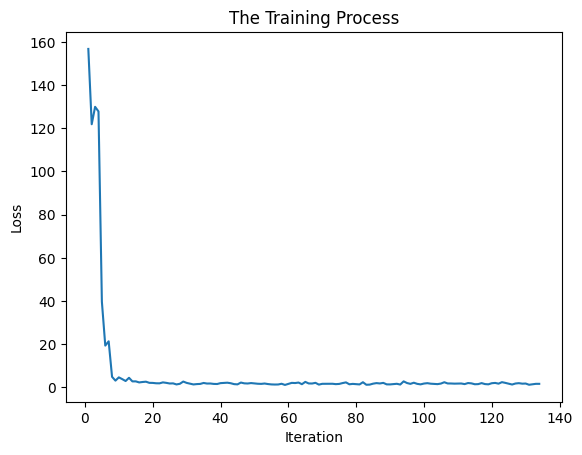

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 172.49it/s]


In [24]:
if __name__ == "__main__":  
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    train_data_path = "./data/covid.train.csv"
    test_data_path = "./data/covid.test.csv"
    save_path = "CovidPredictor"
    csv_saved_path = "result.csv"
    feature_dim = 70
    
    train_dataset = CovidDataset(train_data_path, 'train', feature_dim, feature_index=None)
    feature_index = train_dataset.feature_used
    val_dataset = CovidDataset(train_data_path, 'val', feature_dim, feature_index=None)
    test_dataset = CovidDataset(test_data_path, 'test', feature_dim, feature_index)
    
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=256, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)
    
    model = CovidPredictor(feature_dim)
    loss_function = torch.nn.MSELoss()
    optimizer = torch.optim.Rprop(model.parameters(), lr=0.000001)
    
    iter_list, loss_list = train_val_model(train_loader, val_loader, model, loss_function, optimizer, save_path, device)
    plot_train_process(iter_list, loss_list)
    
    complete_csv(csv_saved_path, predict(save_path, test_loader, device))